In [1]:
import keras as k
import keras.layers as l
from keras.models import load_model
import dataset_tools as dt
import cv2
import csv
import imageio

import random
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from PIL import Image
import json
import pickle

import pylab as pl
from IPython import display

Using TensorFlow backend.


In [2]:
dataset_1 = '/home/jupyter/data/deepfake/datasets/faces/Actor_01_aligned/'
dataset_2 = '/home/jupyter/data/deepfake/datasets/faces/Actor_02_aligned/'

pics_a = dt.get_pics(dataset_1,-1)
pics_b = dt.get_pics(dataset_2,-1)

## Abstract root class

In [3]:
class df_net:    
    def __init__(self,pics_a, pics_b, ratio = 0.9, DIM = 100):
        self.DIM = DIM
        Xa, Xb = dt.format_images(pics_a, pics_b, DIM, DIM)
        self.train_a, self.test_a = dt.separate_dataset(Xa, ratio)
        self.train_b, self.test_b = dt.separate_dataset(Xb, ratio)
        
        self.history = {"lossa" : [], "lossb" : []}     
    def train(self, n_epochs = 1, verbose=0) :

        
        print("Epoch 0 / %d" % (n_epochs), end='\r')
        for n in range(n_epochs):
            hista = self.ae_a.fit(self.train_a, self.train_a, epochs=1, verbose=verbose)
            histb = self.ae_b.fit(self.train_b, self.train_b, epochs=1, verbose=verbose)
            
            print("Epoch %d / %d (loss_a = %f, loss_b = %f)                 "
                  % ((n+1),n_epochs,round(hista.history['loss'][0],4), round(histb.history['loss'][0],4)))
            
            self.history["lossa"].append( hista.history["loss"][0] )
            self.history["lossb"].append( histb.history["loss"][0] )
            
    def save(self, folder) :
        os.makedirs(folder, exist_ok=True)
        self.ae_a.save(folder + "/ae_a.h5")
        self.ae_b.save(folder + "/ae_b.h5")
        
        with open(folder + "/history.pickle", 'wb') as handle:
            pickle.dump(self.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    def load(self, folder) :
        self.ae_a = load_model(folder + "/ae_a.h5")
        self.ae_b = load_model(folder + "/ae_b.h5")

## Dense networks

In [83]:
class dense_simple(df_net):
    def __init__(self,pics_a, pics_b):
        df_net.__init__(self, pics_a, pics_b)
        self.create_network()
        
    def create_network(self) :
        DIM = self.DIM
        input_layer = l.Input(shape = (DIM * DIM,))
        encoded = l.Dense(32, activation='relu')(input_layer)
        decoded_a = l.Dense(DIM*DIM, activation = "sigmoid")(encoded)
        decoded_b = l.Dense(DIM*DIM, activation = "sigmoid")(encoded)
        self.ae_a = k.Model(input_layer, decoded_a)
        self.ae_b = k.Model(input_layer, decoded_b)
        encodeur = k.Model(input_layer, encoded)
        
        self.ae_a.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.ae_b.compile(optimizer='adadelta', loss='binary_crossentropy')

In [4]:
class dense_medium(df_net):
    def __init__(self,pics_a, pics_b):
        df_net.__init__(self, pics_a, pics_b)
        self.create_network()
        
    def create_network(self) :
        DIM = self.DIM
        input_layer = l.Input(shape = (DIM * DIM,))
        encoded = l.Dense(1024, activation='relu')(input_layer)
        encoded = l.Dense(64, activation='relu')(encoded)
        
        decoded_a = l.Dense(1024, activation = "sigmoid")(encoded)
        decoded_a = l.Dense(DIM*DIM, activation = "sigmoid")(decoded_a)
        
        decoded_b = l.Dense(1024, activation = "sigmoid")(encoded)
        decoded_b = l.Dense(DIM*DIM, activation = "sigmoid")(decoded_b)
        
        self.ae_a = k.Model(input_layer, decoded_a)
        self.ae_b = k.Model(input_layer, decoded_b)
        encodeur = k.Model(input_layer, encoded)
        
        self.ae_a.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.ae_b.compile(optimizer='adadelta', loss='binary_crossentropy')

## CNN networks

In [ ]:
class cnn_simple(df_net):
    def __init__(self,pics_a, pics_b, ratio = 0.9):
        df_net.__init__(self, pics_a, pics_b, ratio)
        
        #reshaping for CNN
        self.train_a = self.train_a.reshape((len(self.train_a), 100,100,1))
        self.train_b = self.train_b.reshape((len(self.train_b), 100,100,1))
        self.test_a = self.test_a.reshape((len(self.test_a), 100,100,1))
        self.test_b = self.test_b.reshape((len(self.test_b), 100,100,1))
        
        self.create_network()
        
    def create_network(self) :
        input_img = l.Input(shape=(self.DIM, self.DIM, 1))  # adapt this if using `channels_first` image data format

        x = l.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        encoded = l.MaxPooling2D((2, 2), padding='same')(x)

        # at this point the representation is (4, 4, 8) i.e. 128-dimensional

        xa = l.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(8, (3, 3), activation='relu', padding='same')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(16, (3, 3), activation='relu')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        decoded_a = l.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(xa)

        xb = l.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(8, (3, 3), activation='relu', padding='same')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(16, (3, 3), activation='relu')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        decoded_b = l.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(xb)

        self.ae_a = k.Model(input_img, decoded_a)
        self.ae_b = k.Model(input_img, decoded_b)

        encoder = k.Model(input_img, encoded)
        
        self.ae_a.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.ae_b.compile(optimizer='adadelta', loss='binary_crossentropy')

In [9]:
class cnn_medium(df_net):
    def __init__(self,pics_a, pics_b):
        df_net.__init__(self, pics_a, pics_b, 0.9, 104)
        
        #reshaping for CNN
        self.train_a = self.train_a.reshape((len(self.train_a), 104,104,1))
        self.train_b = self.train_b.reshape((len(self.train_b), 104,104,1))
        self.test_a = self.test_a.reshape((len(self.test_a), 104,104,1))
        self.test_b = self.test_b.reshape((len(self.test_b), 104,104,1))
        
        self.create_network()
        
    def create_network(self) :
        input_img = l.Input(shape=(self.DIM, self.DIM, 1))  # adapt this if using `channels_first` image data format

        x = l.Conv2D(16, (10, 10), activation='relu', padding='same')(input_img)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
        encoded = l.MaxPooling2D((2, 2), padding='same')(x)

        xa = l.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(16, (5, 5), activation='relu')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        decoded_a = l.Conv2D(1, (10, 10), activation='sigmoid', padding='same')(xa)

        xb = l.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(16, (5, 5), activation='relu')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        decoded_b = l.Conv2D(1, (10, 10), activation='sigmoid', padding='same')(xb)

        self.ae_a = k.Model(input_img, decoded_a)
        self.ae_b = k.Model(input_img, decoded_b)

        encoder = k.Model(input_img, encoded)

        self.ae_a.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.ae_b.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
class cnn_big(df_net):
    def __init__(self,pics_a, pics_b):
        df_net.__init__(self, pics_a, pics_b, 0.9, 104)
        
        #reshaping for CNN
        self.train_a = self.train_a.reshape((len(self.train_a), 104,104,1))
        self.train_b = self.train_b.reshape((len(self.train_b), 104,104,1))
        self.test_a = self.test_a.reshape((len(self.test_a), 104,104,1))
        self.test_b = self.test_b.reshape((len(self.test_b), 104,104,1))
        
        self.create_network()
        
    def create_network(self) :
        input_img = l.Input(shape=(self.DIM, self.DIM, 1))  # adapt this if using `channels_first` image data format
        
        x = l.Conv2D(16, (10, 10), activation='relu', padding='same')(input_img)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
        encoded = l.MaxPooling2D((2, 2), padding='same')(x)

        # at this point the representation is (4, 4, 8) i.e. 128-dimensional

        xa = l.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(16, (5, 5), activation='relu')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        decoded_a = l.Conv2D(1, (10, 10), activation='sigmoid', padding='same')(xa)

        xb = l.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(16, (5, 5), activation='relu')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        decoded_b = l.Conv2D(1, (10, 10), activation='sigmoid', padding='same')(xb)

        self.ae_a = k.Model(input_img, decoded_a)
        self.ae_b = k.Model(input_img, decoded_b)

        encoder = k.Model(input_img, encoded)

        self.ae_a.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.ae_b.compile(optimizer='adadelta', loss='binary_crossentropy')

# Display functions

In [94]:
def gen_fake_cnn(df_cnn, dim, count):
    indexes = [0, 200, 400, 600, 800, 1000, 1200, 1400]
    for i in range(1,count+1):
        plt.subplot(3,count,i)
        test_img = df_cnn.test_b[indexes[i]]
        fig = plt.imshow(test_img.reshape(dim,dim), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    for i in range(1,count+1):
        plt.subplot(3,count,i+count)
        test_img = df_cnn.test_b[indexes[i]]
        pred = df_cnn.ae_b.predict(test_img.reshape(1,dim,dim,1))
        fig = plt.imshow(pred.reshape(dim,dim), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
    for i in range(1,count+1):
        plt.subplot(3,count,i+count*2)
        test_img = df_cnn.test_b[indexes[i]]
        pred = df_cnn.ae_a.predict(test_img.reshape(1,dim,dim,1))
        fig = plt.imshow(pred.reshape(dim,dim), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [7]:
def gen_fake_dense(df_dense, dim, count):
    indexes = [0, 200, 400, 600, 800, 1000, 1200, 1400]
    for i in range(1,count+1):
        plt.subplot(3,count,i)
        test_img = df_dense.test_b[indexes[i]]
        fig = plt.imshow(test_img.reshape(dim,dim), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    for i in range(1,count+1):
        plt.subplot(3,count,i+count)
        test_img = df_dense.test_b[indexes[i]]
        pred = df_dense.ae_b.predict(np.array([test_img]))
        fig = plt.imshow(pred.reshape(100,100), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
    for i in range(1,count+1):
        plt.subplot(3,count,i+count*2)
        test_img = df_dense.test_b[indexes[i]]
        pred = df_dense.ae_a.predict(np.array([test_img]))
        fig = plt.imshow(pred.reshape(100,100), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

# Save function

In [ ]:
def savecurrentgen(gen) :

    indexes = [0, 200, 400, 600, 800, 1000, 1200]
    
    for i in indexes:
        fig = df_cnn.test_a[i].reshape(104, 104)
        

        bwimg = Image.fromarray(fig)
        rgbimg = Image.new("RGBA", bwimg.size)

        rgbimg.paste(bwimg)

        rgbimg.save("training_imgs2/" + str(gen) + "_original_" + str(i) + ".png")
        
    for i in indexes:
        test_img = df_cnn.test_b[i]
        
        pred = df_cnn.ae_b.predict(test_img.reshape(1,104,104,1)).reshape(104,104)
                
        bwimg = Image.fromarray(fig)
        rgbimg = Image.new("RGBA", bwimg.size)

        rgbimg.paste(bwimg)

        rgbimg.save("training_imgs2/" + str(gen) + "_aeb_" + str(i) + ".png")
        
    for i in indexes:
        test_img = df_cnn.test_b[i]
        
        pred = df_cnn.ae_a.predict(test_img.reshape(1,104,104,1)).reshape(104,104)
        bwimg = Image.fromarray(fig)
        rgbimg = Image.new("RGBA", bwimg.size)

        rgbimg.paste(bwimg)

        rgbimg.save("training_imgs2/" + str(gen) + "_aea_" + str(i) + ".png")


In [1]:
#saves loss history to csv

dict = df_cnn.history
w = csv.writer(open("history.csv", "w"))
for key, val in dict.items():
    w.writerow([key, val])

NameError: name 'df_cnn' is not defined

# Dense network test bench

In [5]:
df_dense = dense_medium(pics_a, pics_b)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


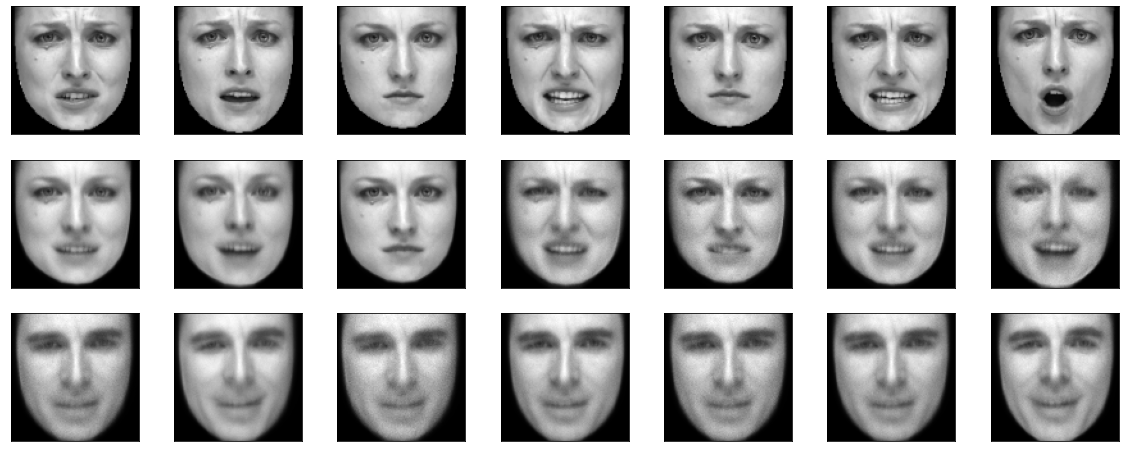

Epoch 1 / 10 (loss_a = 0.520800, loss_b = 0.516900)                 
Epoch 2 / 10 (loss_a = 0.520600, loss_b = 0.516800)                 


KeyboardInterrupt: 

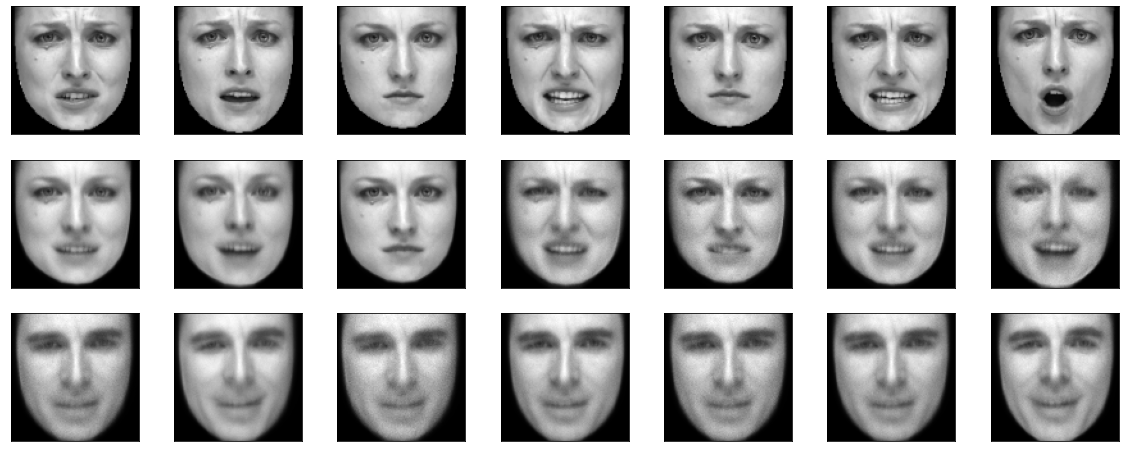

In [8]:
plt.figure(figsize=(20,8))

while(True):    
    gen_fake_dense(df_dense, 100, 7)
    
    #clear display
    display.clear_output(wait=True)
    display.display(pl.gcf())
        
    df_dense.train(10)

# CNN test bench

In [10]:
df_cnn = cnn_medium(pics_a, pics_b)
df_cnn.load("models/medium_new_cnn_aligned_full2")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



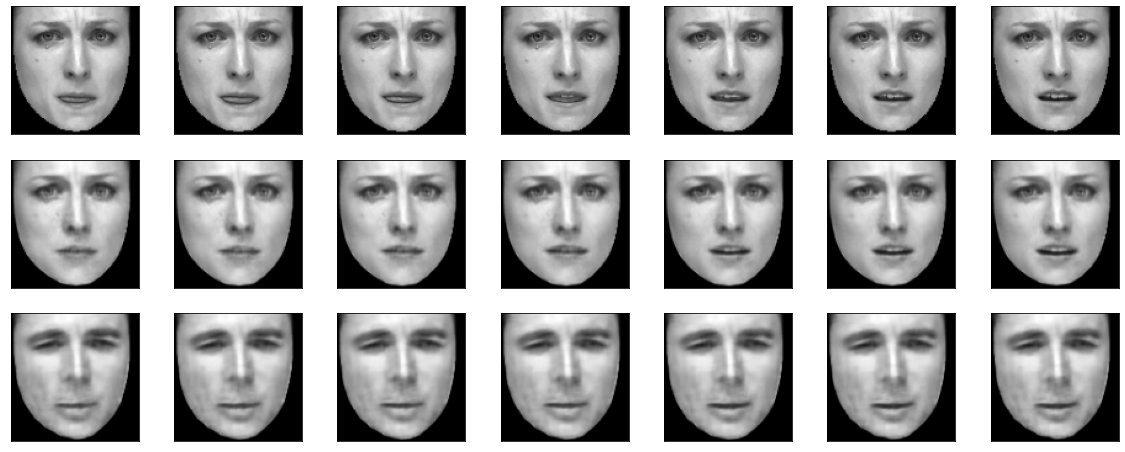

Epoch 1 / 10 (loss_a = 0.512100, loss_b = 0.510900)                 
Epoch 2 / 10 (loss_a = 0.512100, loss_b = 0.510900)                 
Epoch 3 / 10 (loss_a = 0.512100, loss_b = 0.510900)                 
Epoch 4 / 10 (loss_a = 0.512100, loss_b = 0.510900)                 
Epoch 5 / 10 (loss_a = 0.512100, loss_b = 0.510900)                 


KeyboardInterrupt: 

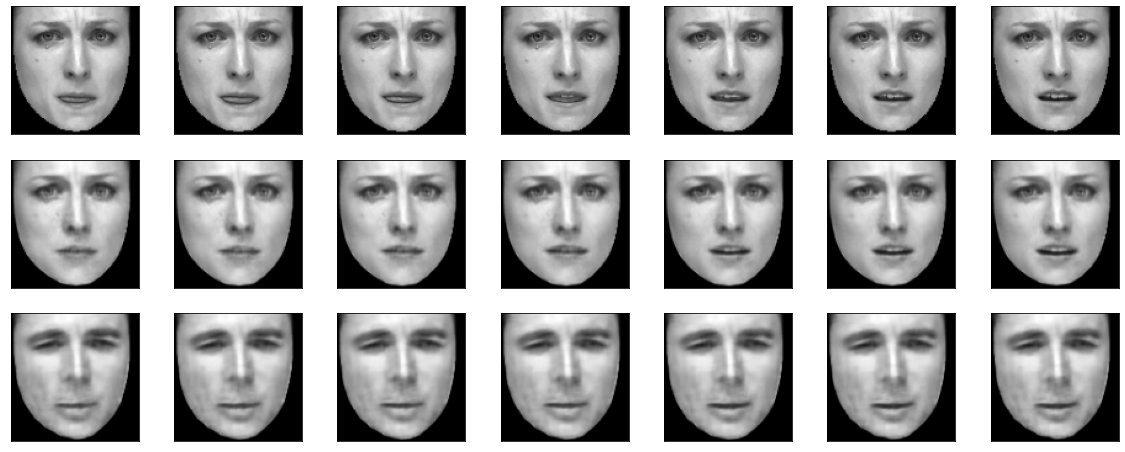

In [9]:
plt.figure(figsize=(20,8))

gen = 0
while(True):
    gen_fake_cnn(df_cnn, 104, 7)
    
    #clear display
    display.clear_output(wait=True)
    display.display(pl.gcf())
    
    df_cnn.train(10)
    
    savecurrentgen(gen)
    df_cnn.save("models/medium_new_cnn_aligned_full2")
        
    gen += 10

In [ ]:
df_cnn.save("medium_new_cnn_aligned_full")

# Sauvegarde du gif

In [26]:
gif_source = {"orignal" : [], "generated" : []}

gif_source["original"] = df_cnn.test_b.copy()

pred = df_cnn.ae_a.predict(df_cnn.test_b)
gif_source["generated"] = pred

In [ ]:
imageio.mimsave('original_2.gif', gif_source["original"] * 255)
imageio.mimsave('generated_2.gif', gif_source["generated"] * 255)

# Blurriness

In [22]:
cv2.Laplacian(df_cnn.test_b[0], cv2.CV_64F).var()   

0.006087382876779172

In [36]:
m = [0,0]

for i in range(len(df_cnn.test_b)):
    m[0] += cv2.Laplacian(df_cnn.test_b[i] * 255, cv2.CV_64F).var()
    m[0] += cv2.Laplacian(gif_source['generated'][0].reshape((104,104)) * 255, cv2.CV_64F).var()
    
    
np.array(m)/(len(df_cnn.test_b))

error: OpenCV(4.2.0) /home/conda/feedstock_root/build_artifacts/libopencv_1586998986183/work/modules/imgproc/src/filter.simd.hpp:3175: error: (-213:The function/feature is not implemented) Unsupported combination of source format (=5), and destination format (=6) in function 'getLinearFilter'


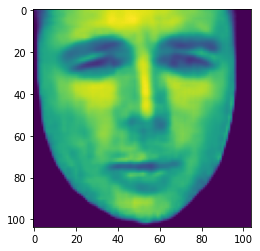

In [35]:
plt.imshow(gif_source['generated'][0].reshape((104,104)) * 255)

In [73]:
import cv2

In [77]:
img = gif_source['generated'][0]

In [75]:
img = df_cnn.test_b[0]

In [80]:
cv2.Laplacian(img *255 , cv2.CV_64F)

error: OpenCV(4.2.0) /home/conda/feedstock_root/build_artifacts/libopencv_1586998986183/work/modules/imgproc/src/filter.simd.hpp:3175: error: (-213:The function/feature is not implemented) Unsupported combination of source format (=5), and destination format (=6) in function 'getLinearFilter'


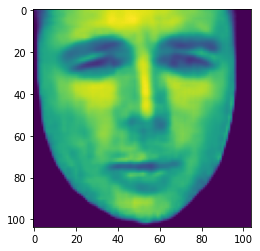

In [81]:
plt.imshow((img * 255).reshape(104,104))

In [82]:
img * 255

array([[[13.000129],
        [21.645622],
        [31.945547],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]],

       [[ 5.513527],
        [12.791132],
        [26.45751 ],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]],

       [[ 4.989505],
        [13.231878],
        [28.525951],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]],

       ...,

       [[ 0.      ],
        [ 0.      ],
        [ 0.      ],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]],

       [[ 0.      ],
        [ 0.      ],
        [ 0.      ],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]],

       [[ 0.      ],
        [ 0.      ],
        [ 0.      ],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]]], dtype=float32)

In [71]:
gif_source['generated'][0]

array([[[0.0509809 ],
        [0.08488479],
        [0.12527665],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.02162167],
        [0.0501613 ],
        [0.10375494],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.01956668],
        [0.05188972],
        [0.11186647],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]], dtype=float32)